# A simple experiment with the analytical queueing model

In [1]:
import ranking_and_selection as rs
import queueing_model as qm
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [78]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_simulation.json') as json_file:
    data_as_is_simulation = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_analytical.json') as json_file:
    data_as_is_analytical = json.load(json_file)

Here we perform a simple experiment in order to understand the effects of three different factors on the value of a simple objective function when we decide to build housing or shelter, and therefore our preference for housing or shelter. The three different factors are: 

* the point in time at which we add accommodation (housing or shelter)
* the relative cost of shelter compared to housing
* the rate at which customers are served in housing

We aim to isolate the effects of each of the three factors in order to gain this understanding. 

## Experiment setup

We start with the following 'as-is' parameters for the analytical model, which in part originate from the analytical counterpart of the simulation model of Singham et al. (2023) (i.e. the initial capacity, the time between changes in build rate and the time between building) but also include parameters which prove convenient for studying the behaviour of the queues (i.e. the initial demand, arrival rates and the analysis horizon). 

In [99]:
# Opening JSON file
with open('data_as_is_exp1.json') as json_file:
    data_as_is_exp1 = json.load(json_file)

In [100]:
print('Length of model run (yrs): ' + str(data_as_is_exp1['analysis_horizon']))
print('Initial capacity: ' + str(data_as_is_exp1['initial_capacity']))
print('Initial demand: ' + str(data_as_is_exp1['initial_demand']))
for i in range(len(data_as_is_exp1['arrival_rates'])):
    print('Arrival rates yr ' + str(i+1) + ': ' + str(data_as_is_exp1['arrival_rates'][i]))
print('Time between changes in the build rate (weeks): ' + str(int(data_as_is_exp1['time_btwn_changes_in_build_rate']*365/7)))
print('Time between building (weeks): ' + str(int(data_as_is_exp1['time_btwn_building']*365/7)))

Length of model run (yrs): 4
Initial capacity: {'housing': 40, 'shelter': 15}
Initial demand: 180
Arrival rates yr 1: 40
Arrival rates yr 2: 40
Arrival rates yr 3: 40
Arrival rates yr 4: 40
Time between changes in the build rate (weeks): 54
Time between building (weeks): 9


The two parameters left out above which we want to experiment with are the service times and the build rates. The service time for shelter we always set as 0, and for the housing service time means we will look at a range (and a correpsponding range of housing service rates): 

In [5]:
service_times = [1,2,3,4,5]
print('Housing service time means - range to be studied (yrs): ' + str(service_times))
print('Housing service rates - range to be studied (1/yrs): ' + str([round(1/i,2) for i in service_times]))

Housing service time means - range to be studied (yrs): [1, 2, 3, 4, 5]
Housing service rates - range to be studied (1/yrs): [1.0, 0.5, 0.33, 0.25, 0.2]


For the build rates, we start with a baseline of building 12 extra housing and 12 extra shelter units every year, for 4 years: 

In [104]:
sol = [{'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, 12]}]
print(sol)

[{'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, 12]}]


This gives us the following objective function values, with a simple objective function of the expected value of the time-averaged unsheltered queue: 

In [105]:
out = []
for i in range(len(service_times)):
    spc = rs.SolutionSpace(sol)
    spc.model_analytically(data_as_is_exp1, data_as_is_analytical, data_as_is_exp1['analysis_horizon'], float(service_times[i]))
    out.append(spc.true_outputs_unsh[0])

In [106]:
for i in range(len(out)):
    print('Service rate: ' + str(round(1/service_times[4-i],2)) + ', Obj value: ' + str(round(out[4-i],2)))

Service rate: 0.2, Obj value: 133.97
Service rate: 0.25, Obj value: 128.34
Service rate: 0.33, Obj value: 118.95
Service rate: 0.5, Obj value: 100.17
Service rate: 1.0, Obj value: 52.66


We then experiment with adding to our baseline build rate in 8 different ways - adding extra shelter or adding extra housing in one of each of the four years. For this extra accommodation, we have budget equivalent to 60 houses. If we choose to spend that on housing then in one of four years we can build 60 extra houses. If we decide to add extra shelter in a particular year, then the amount of extra shelter units which we add depends on the cost of a shelter unit compared to housing. This cost we range from 1 to 0.25:

In [112]:
hx = 60 # base amount of extra accomm
additional_shelter = [hx + i*6 for i in range(31)]
print('Cost of shelter (as proportion of cost of housing) - range to be studied: ' + str([round(hx/i,2) for i in additional_shelter]))

Cost of shelter (as proportion of cost of housing) - range to be studied: [1.0, 0.91, 0.83, 0.77, 0.71, 0.67, 0.62, 0.59, 0.56, 0.53, 0.5, 0.48, 0.45, 0.43, 0.42, 0.4, 0.38, 0.37, 0.36, 0.34, 0.33, 0.32, 0.31, 0.3, 0.29, 0.29, 0.28, 0.27, 0.26, 0.26, 0.25]


The effect of these costs is that if we add extra shelter units in a particular year, the amount that we add falls in the following range: 

In [114]:
print('The amount of additional shelter we may build: ' + str(additional_shelter))

The amount of additional shelter we may build: [60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240]


In summary: for every combination of 'housing service rate' and 'cost of shelter units', we model 8 different solutions with the build rates given below, where 'bx' is the amount of extra housing we can afford (60 units) and 'sx' depends on the cost of shelter. And for all of these solutions, the dynamics of the model run depends on the 'housing service rate' which we are using. These 8 solutions effectively amount to adding either extra shelter or extra housing in one of each of the four years. 

In [115]:
sols = [{'housing': ['12+bx', 12, 12, 12], 'shelter': [12, 12, 12, 12]},
        {'housing': [12, '12+bx', 12, 12], 'shelter': [12, 12, 12, 12]},
        {'housing': [12, 12, '12+bx', 12], 'shelter': [12, 12, 12, 12]},
        {'housing': [12, 12, 12, '12+bx'], 'shelter': [12, 12, 12, 12]},
        {'housing': [12, 12, 12, 12], 'shelter': ['12+sx', 12, 12, 12]},
        {'housing': [12, 12, 12, 12], 'shelter': [12, '12+sx', 12, 12]},
        {'housing': [12, 12, 12, 12], 'shelter': [12, 12, '12+sx', 12]},
        {'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, '12+sx']}]
for i in range(len(sols)):
    print(sols[i])

{'housing': ['12+bx', 12, 12, 12], 'shelter': [12, 12, 12, 12]}
{'housing': [12, '12+bx', 12, 12], 'shelter': [12, 12, 12, 12]}
{'housing': [12, 12, '12+bx', 12], 'shelter': [12, 12, 12, 12]}
{'housing': [12, 12, 12, '12+bx'], 'shelter': [12, 12, 12, 12]}
{'housing': [12, 12, 12, 12], 'shelter': ['12+sx', 12, 12, 12]}
{'housing': [12, 12, 12, 12], 'shelter': [12, '12+sx', 12, 12]}
{'housing': [12, 12, 12, 12], 'shelter': [12, 12, '12+sx', 12]}
{'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, '12+sx']}


## Results

The charts below illustrate the results for the objective function of each solution. Each box is a selected combination of the housing service rate and the cost of shelter. Within each box we plot with a dot the objective value of each of the eight solutions. We plot these objective values as a function of the year in which we added extra accommodation. 

In [23]:
# Explore range of shelter costs and service time distributions
print('start at time ' + str(datetime.datetime.now()))

housing_imprv_all1_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all1_obj1 = [[] for i in range(len(additional_shelter))]
housing_imprv_all1_obj2 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all1_obj2 = [[] for i in range(len(additional_shelter))]
housing_imprv_all1_obj3 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all1_obj3 = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [12+hx, 12, 12, 12], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12+hx, 12, 12], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12, 12+hx, 12], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12, 12, 12+hx], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12+sx, 12, 12, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12, 12+sx, 12, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12+sx, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, 12+sx]}]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_as_is_exp1, data_as_is_analytical, data_as_is_exp1['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []
        housing_imprv2 = []
        shelter_imprv2 = []
        housing_imprv3 = []
        shelter_imprv3 = []
        
        for k in range(data_as_is_exp1['analysis_horizon']):
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)
            # ----
            imprv = spc.true_outputs_unsh[k] + 0.5 * spc.true_outputs_sh[k]
            housing_imprv2.append(imprv)
            imprv = spc.true_outputs_unsh[k+4] + 0.5 * spc.true_outputs_sh[k+4]
            shelter_imprv2.append(imprv)            
            # ----
            imprv = (spc.true_outputs_unsh[k]**2) + 0.5 * (spc.true_outputs_sh[k]**2)
            housing_imprv3.append(imprv)
            imprv = (spc.true_outputs_unsh[k+4]**2) + 0.5 * (spc.true_outputs_sh[k+4]**2)
            shelter_imprv3.append(imprv)
        
        housing_imprv_all1_obj1[i].append(housing_imprv1)
        shelter_imprv_all1_obj1[i].append(shelter_imprv1)
        housing_imprv_all1_obj2[i].append(housing_imprv2)
        shelter_imprv_all1_obj2[i].append(shelter_imprv2) 
        housing_imprv_all1_obj3[i].append(housing_imprv3)
        shelter_imprv_all1_obj3[i].append(shelter_imprv3) 
        
        print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

start at time 2023-11-16 12:23:02.206658
done (0, 0) at time 2023-11-16 12:23:31.512535
done (0, 1) at time 2023-11-16 12:24:00.587573
done (0, 2) at time 2023-11-16 12:24:29.801607
done (0, 3) at time 2023-11-16 12:24:59.215136
done (0, 4) at time 2023-11-16 12:25:28.748929
done (1, 0) at time 2023-11-16 12:25:57.763233
done (1, 1) at time 2023-11-16 12:26:27.275727
done (1, 2) at time 2023-11-16 12:26:56.881527
done (1, 3) at time 2023-11-16 12:27:26.305436
done (1, 4) at time 2023-11-16 12:27:55.913745
done (2, 0) at time 2023-11-16 12:28:25.352856
done (2, 1) at time 2023-11-16 12:28:54.752908
done (2, 2) at time 2023-11-16 12:29:24.206263
done (2, 3) at time 2023-11-16 12:29:53.819506
done (2, 4) at time 2023-11-16 12:30:23.249335
done (3, 0) at time 2023-11-16 12:30:52.485089
done (3, 1) at time 2023-11-16 12:31:21.806785
done (3, 2) at time 2023-11-16 12:31:51.058456
done (3, 3) at time 2023-11-16 12:32:20.586741
done (3, 4) at time 2023-11-16 12:32:49.882842
done (4, 0) at time

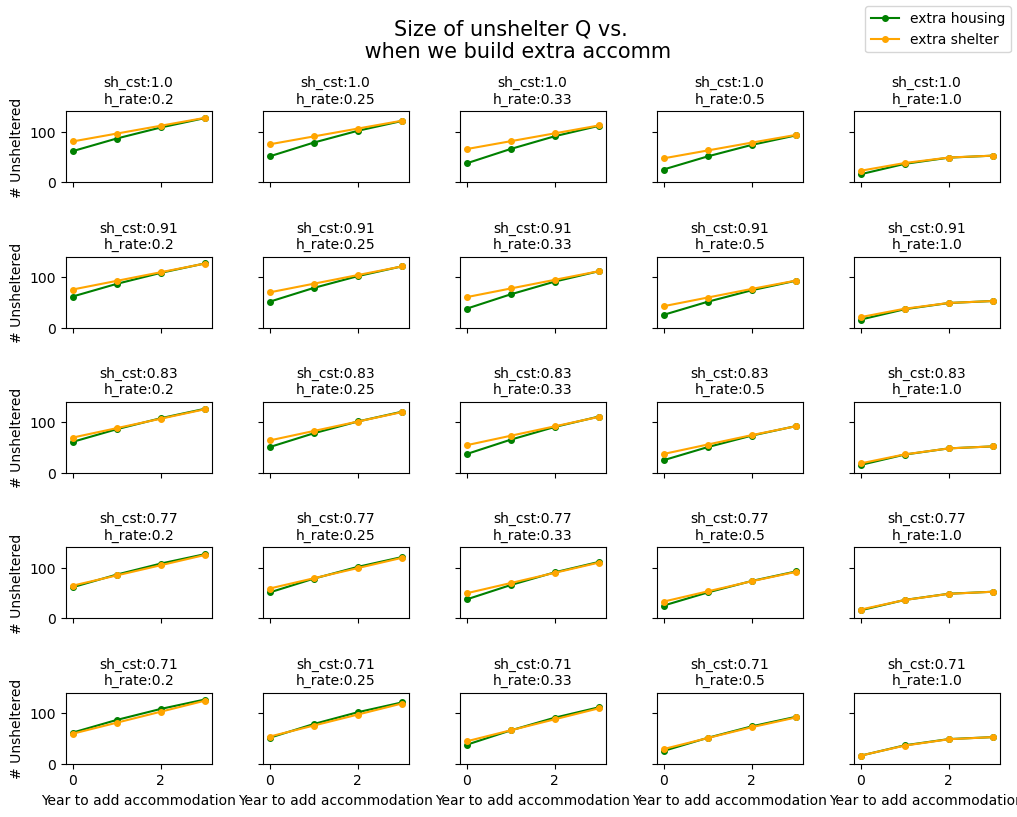

In [27]:
title1 = 'sh_cst:'
title2 = 'h_rate:'
x = [0,1,2,3]
n_rw = len(additional_shelter)
n_cl = len(service_times)
fig, axs = plt.subplots(n_rw, n_cl,  figsize=(10, 8))
for i in range(n_rw):
    for j in range(n_cl):
        line1, = axs[i, j].plot(x, housing_imprv_all1_obj1[i][n_cl -1 - j], color = 'green', label = 'extra housing', marker='o', markersize = 4)
        line2, = axs[i, j].plot(x, shelter_imprv_all1_obj1[i][n_cl -1 - j], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
        axs[i, j].set_title(title1 + 
                            str(round(bx/(additional_shelter[i]),2)) + 
                            '\n' + 
                            title2 + 
                            str(round(1/service_times[n_cl -1 - j],2)), fontsize = 10)
        axs[i, j].set_ylim(0,140)

plt.suptitle('Size of unshelter Q vs. \n when we build extra accomm', fontsize = 15)            
fig.legend(handles=[line1, line2]) 
fig.tight_layout()
            
for ax in axs.flat:
    ax.set(xlabel='Year to add accommodation', ylabel='# Unsheltered')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### What do we know?

Assumming an objective function of the expected value of the time average of the size of the unsheltered Q:
* If we add accomm later, the objective func. value for the full time horizon will increase
* When housing/shelter cost the same, extra housing is always better than extra shelter, because it takes someone out of the unsheltered and increases the overall rate at which people leave the system. 
    * The amount by which we prefer extra housing decreases if you add it later
* When we reduce cost of shelter, the obj value for adding extra shelter decreases until we eventually prefer shelter. The 'shelter cost' at which this crossover (in preference) occurs is different for the different years of the model run, starting with later years. This makes sense because in later years, the benefit of extra housing is less than in earlier years, because there is less time for the benefit to take effect, so in later years, shelter has to only be a little bit cheaper for us to be able to afford enough to make it preferable to housing. As we slowly reduce the cost of shelter, while the crossover in preference takes place, we have solution spaces which indicate an initial preference for housing, followed by a preference for housing. 
* The 'crossover' occurs at a cheaper 'shelter cost' when the housing service rate is increased. 
* When we keep the cost of shelter the same and increase the service rate at housing, we see the effect that the objective value for adding extra shelter decreases, but it decreases more for adding extra housing. However, this effect only holds for when the queue is sufficiently large. 
* Adding extra housing gets worse more 'quickly' - i.e. the benefit you get as a result of increasing the overall rate of leaving system is more sensitive to changing the time at which you add it. 
* Ultimately - if you leave it right to the last minute, assuming shelter is cheaper, shelter will always be preferable, because there is no time for the benefit of housing to have an effect, so if housing starts off being better, we can end up with a mixed optimal (i.e. first better to have housing, then better to have shelter). 

#### What happens if we increase the model run time, but not the times at which decisions are made

The latter point above should not be the case in reality, because having a house will have benefits which stretch longer than just the time at which the decision is made. So we can try modelling the system for 10 years, but only making decisions about the first 4 yrs. 

In [126]:
# Opening JSON file
with open('data_as_is_exp2.json') as json_file:
    data_as_is_exp2 = json.load(json_file)

In [84]:
# Explore range of shelter costs and service time distributions
print('start at time ' + str(datetime.datetime.now()))

b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 6*i for i in range(31)]
service_times = [1,2,3,4,5]

housing_imprv_all2_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all2_obj1 = [[] for i in range(len(additional_shelter))]
housing_imprv_all2_obj2 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all2_obj2 = [[] for i in range(len(additional_shelter))]
housing_imprv_all2_obj3 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all2_obj3 = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b+hx], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s, s+sx]}]
        # expand solution space
        sols = [{'housing' : sols[k]['housing']+[b for l in range(data_as_is_exp2['analysis_horizon'] - yrs_dec)],
                 'shelter' : sols[k]['shelter']+[s for l in range(data_as_is_exp2['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_as_is_exp2, data_as_is_analytical, data_as_is_exp2['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []
        housing_imprv2 = []
        shelter_imprv2 = []
        housing_imprv3 = []
        shelter_imprv3 = []
        
        for k in range(yrs_dec):
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)
            # ----
            imprv = spc.true_outputs_unsh[k] + 0.5 * spc.true_outputs_sh[k]
            housing_imprv2.append(imprv)
            imprv = spc.true_outputs_unsh[k+4] + 0.5 * spc.true_outputs_sh[k+4]
            shelter_imprv2.append(imprv)            
            # ----
            imprv = (spc.true_outputs_unsh[k]**2) + 0.5 * (spc.true_outputs_sh[k]**2)
            housing_imprv3.append(imprv)
            imprv = (spc.true_outputs_unsh[k+4]**2) + 0.5 * (spc.true_outputs_sh[k+4]**2)
            shelter_imprv3.append(imprv)
        
        housing_imprv_all2_obj1[i].append(housing_imprv1)
        shelter_imprv_all2_obj1[i].append(shelter_imprv1)
        housing_imprv_all2_obj2[i].append(housing_imprv2)
        shelter_imprv_all2_obj2[i].append(shelter_imprv2) 
        housing_imprv_all2_obj3[i].append(housing_imprv3)
        shelter_imprv_all2_obj3[i].append(shelter_imprv3) 
        
        print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

start at time 2023-11-16 16:18:49.024781
done (0, 0) at time 2023-11-16 16:19:56.289540
done (0, 1) at time 2023-11-16 16:21:03.669967
done (0, 2) at time 2023-11-16 16:22:10.352516
done (0, 3) at time 2023-11-16 16:23:17.788711
done (0, 4) at time 2023-11-16 16:24:24.873558
done (1, 0) at time 2023-11-16 16:25:31.428672
done (1, 1) at time 2023-11-16 16:26:38.004665
done (1, 2) at time 2023-11-16 16:27:45.722787
done (1, 3) at time 2023-11-16 16:28:53.080610
done (1, 4) at time 2023-11-16 16:30:00.393666
done (2, 0) at time 2023-11-16 16:31:07.646345
done (2, 1) at time 2023-11-16 16:32:15.712965
done (2, 2) at time 2023-11-16 16:33:22.754697
done (2, 3) at time 2023-11-16 16:34:30.086465
done (2, 4) at time 2023-11-16 16:35:38.453149
done (3, 0) at time 2023-11-16 16:36:46.767373
done (3, 1) at time 2023-11-16 16:37:54.880606
done (3, 2) at time 2023-11-16 16:39:01.585266
done (3, 3) at time 2023-11-16 16:40:08.732380
done (3, 4) at time 2023-11-16 16:41:17.630827
done (4, 0) at time

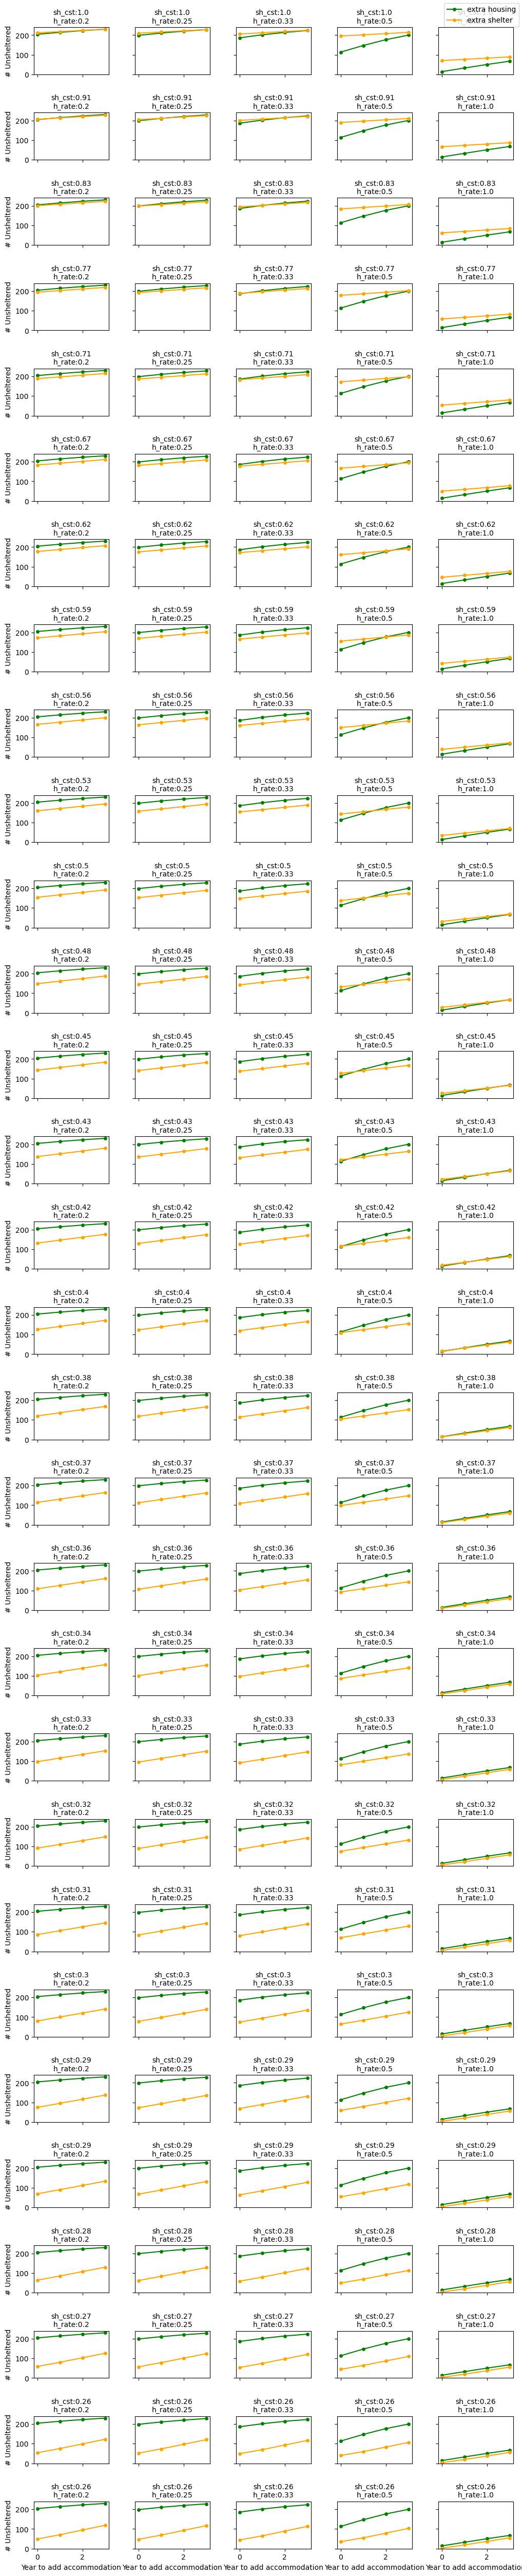

In [89]:
title1 = 'sh_cst:'
title2 = 'h_rate:'
x = [0,1,2,3]
n_rw = len(additional_shelter)
n_cl = len(service_times)
fig, axs = plt.subplots(n_rw, n_cl,  figsize=(10, 50))
for i in range(n_rw):
    for j in range(n_cl):
        line1, = axs[i, j].plot(x, housing_imprv_all2_obj1[i][n_cl -1 - j], color = 'green', label = 'extra housing', marker='o', markersize = 4)
        line2, = axs[i, j].plot(x, shelter_imprv_all2_obj1[i][n_cl -1 - j], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
        axs[i, j].set_title(title1 + 
                            str(round(hx/(additional_shelter[i]),2)) + 
                            '\n' + 
                            title2 + 
                            str(round(1/service_times[n_cl -1 - j],2)), fontsize = 10)
        axs[i, j].set_ylim(0,240)

#plt.suptitle('Size of unshelter Q vs. \n when we build extra accomm', fontsize = 15)            
fig.legend(handles=[line1, line2]) 
fig.tight_layout()
            
for ax in axs.flat:
    ax.set(xlabel='Year to add accommodation', ylabel='# Unsheltered')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

The findings here in general appear to be the same, but the differences are amplified - because the differences can take effect over a longer period of time. 

#### Looking for a mix in the optimal solution

In [19]:
h = 3 # housing service rate
s = 18 # shelters you can get for the price of 12 housing
sols = [{'housing': [24, 12, 12, 12], 'shelter': [s, s, s, s]},
        {'housing': [12, 24, 12, 12], 'shelter': [s, s, s, s]},
        {'housing': [12, 12, 24, 12], 'shelter': [s, s, s, s]},
        {'housing': [12, 12, 12, 24], 'shelter': [s, s, s, s]},
        {'housing': [12, 12, 12, 12], 'shelter': [2*s, s, s, s]},
        {'housing': [12, 12, 12, 12], 'shelter': [s, 2*s, s, s]},
        {'housing': [12, 12, 12, 12], 'shelter': [s, s, 2*s, s]},
        {'housing': [12, 12, 12, 12], 'shelter': [s, s, s, 2*s]}]
spc = rs.SolutionSpace(sols)
spc.model_analytically(data_as_is, data_as_is_analytical, yrs, h)

housing_imprv1 = []
shelter_imprv1 = []
housing_imprv2 = []
shelter_imprv2 = []
housing_imprv3 = []
shelter_imprv3 = []

for k in range(yrs):
    imprv = spc.true_outputs_unsh[k]
    housing_imprv1.append(imprv)
    imprv = spc.true_outputs_unsh[k+4]
    shelter_imprv1.append(imprv)
    # ----
    imprv = spc.true_outputs_unsh[k] + 0.5 * spc.true_outputs_sh[k]
    housing_imprv2.append(imprv)
    imprv = spc.true_outputs_unsh[k+4] + 0.5 * spc.true_outputs_sh[k+4]
    shelter_imprv2.append(imprv)            
    # ----
    imprv = (spc.true_outputs_unsh[k]**2) + 0.5 * (spc.true_outputs_sh[k]**2)
    housing_imprv3.append(imprv)
    imprv = (spc.true_outputs_unsh[k+4]**2) + 0.5 * (spc.true_outputs_sh[k+4]**2)
    shelter_imprv3.append(imprv)

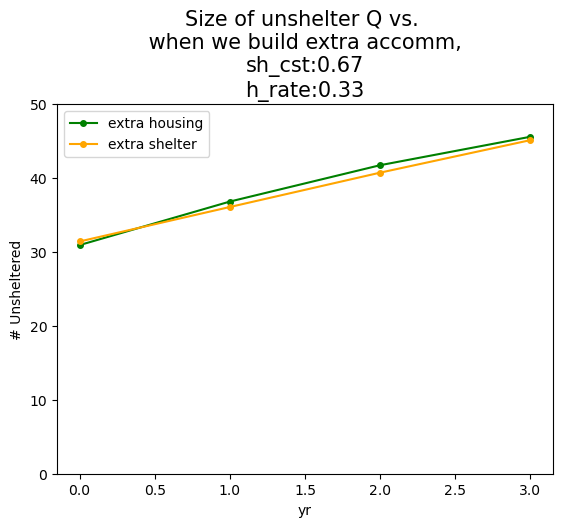

In [20]:
title1 = 'sh_cst:'
title2 = 'h_rate:'
x = [0,1,2,3]
n_rw = 1
n_cl = 1
plt.plot(x, housing_imprv1, color = 'green', label = 'extra housing', marker='o', markersize = 4)
plt.plot(x, shelter_imprv1, color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
plt.title('Size of unshelter Q vs. \n when we build extra accomm, \n' + 
          title1 + 
          str(round(12/s,2)) + 
          '\n' + 
          title2 + 
          str(round(1/h,2)),fontsize = 15)
plt.xlabel('yr')
plt.ylabel('# Unsheltered')
plt.ylim(0,50)
plt.legend()
plt.show()

#### Look at the effect of changing the arrival rate function

Up until now we have had a constant arrival rate function, but we now look at different arrival rate functions. 

* Constant: low
* Constant: medium
* Constant: high

* Increasing: low to high
* Decreasing: high to low
* Spike: low to high to low
* Dip: high to low to high

We build on experiment 1 - where we do not let the model run for multiple years after decisions have been made. We change the arrival rate functions over the four year period in order to analyse the affect. 

In [176]:
arrival_rate_funcs = [[50, 50, 50, 50],
                      [125, 125, 125, 125],
                      [200, 200, 200, 200],
                      [50, 100, 150, 200],
                      [200, 150, 100, 50],
                      [50, 200, 200, 50],
                      [200, 50, 50, 200]]

arrival_rate_func_names = ['Const - low',
                          'Const - med',
                          'Const - high',
                          'Low to high',
                          'High to low',
                          'Spike (low to high to low)',
                          'Dip (high to low to high)']

for i in range(len(arrival_rate_funcs)):
    print(str(arrival_rate_func_names[i]) + ': ' + str(arrival_rate_funcs[i]))

Const - low: [50, 50, 50, 50]
Const - med: [125, 125, 125, 125]
Const - high: [200, 200, 200, 200]
Low to high: [50, 100, 150, 200]
High to low: [200, 150, 100, 50]
Spike (low to high to low): [50, 200, 200, 50]
Dip (high to low to high): [200, 50, 50, 200]


In [183]:
# Explore range of shelter costs and service time distributions
print('start at time ' + str(datetime.datetime.now()))

data_as_is_exp3 = data_as_is_exp1.copy()

b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 12]
sx = additional_shelter[0]
service_times = [3]

housing_imprv_all3_obj1 = [[] for i in range(len(arrival_rate_funcs))]
shelter_imprv_all3_obj1 = [[] for i in range(len(arrival_rate_funcs))]
housing_imprv_all3_obj2 = [[] for i in range(len(arrival_rate_funcs))]
shelter_imprv_all3_obj2 = [[] for i in range(len(arrival_rate_funcs))]
housing_imprv_all3_obj3 = [[] for i in range(len(arrival_rate_funcs))]
shelter_imprv_all3_obj3 = [[] for i in range(len(arrival_rate_funcs))]

for i in range(len(arrival_rate_funcs)):
    sols = [{'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s]},
            {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s]},
            {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s]},
            {'housing': [b, b, b, b+hx], 'shelter': [s, s, s, s]},
            {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s]},
            {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s]},
            {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s]},
            {'housing': [b, b, b, b], 'shelter': [s, s, s, s+sx]}]
    data_as_is_exp3['arrival_rates'] = arrival_rate_funcs[i]
    spc = rs.SolutionSpace(sols)
    spc.model_analytically(data_as_is_exp3, data_as_is_analytical, data_as_is_exp3['analysis_horizon'], float(service_times[j]))

    housing_imprv1 = []
    shelter_imprv1 = []
    housing_imprv2 = []
    shelter_imprv2 = []
    housing_imprv3 = []
    shelter_imprv3 = []

    for k in range(yrs_dec):
        imprv = spc.true_outputs_unsh[k]
        housing_imprv1.append(imprv)
        imprv = spc.true_outputs_unsh[k+4]
        shelter_imprv1.append(imprv)
        # ----
        imprv = spc.true_outputs_unsh[k] + 0.5 * spc.true_outputs_sh[k]
        housing_imprv2.append(imprv)
        imprv = spc.true_outputs_unsh[k+4] + 0.5 * spc.true_outputs_sh[k+4]
        shelter_imprv2.append(imprv)            
        # ----
        imprv = (spc.true_outputs_unsh[k]**2) + 0.5 * (spc.true_outputs_sh[k]**2)
        housing_imprv3.append(imprv)
        imprv = (spc.true_outputs_unsh[k+4]**2) + 0.5 * (spc.true_outputs_sh[k+4]**2)
        shelter_imprv3.append(imprv)

    housing_imprv_all3_obj1[i].append(housing_imprv1)
    shelter_imprv_all3_obj1[i].append(shelter_imprv1)
    housing_imprv_all3_obj2[i].append(housing_imprv2)
    shelter_imprv_all3_obj2[i].append(shelter_imprv2) 
    housing_imprv_all3_obj3[i].append(housing_imprv3)
    shelter_imprv_all3_obj3[i].append(shelter_imprv3) 

    print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

start at time 2023-11-17 16:59:01.672914
done (0, 0) at time 2023-11-17 16:59:29.131460
done (1, 0) at time 2023-11-17 16:59:56.312174
done (2, 0) at time 2023-11-17 17:00:23.908160
done (3, 0) at time 2023-11-17 17:00:51.034894
done (4, 0) at time 2023-11-17 17:01:18.319489
done (5, 0) at time 2023-11-17 17:01:45.329406
done (6, 0) at time 2023-11-17 17:02:12.842613


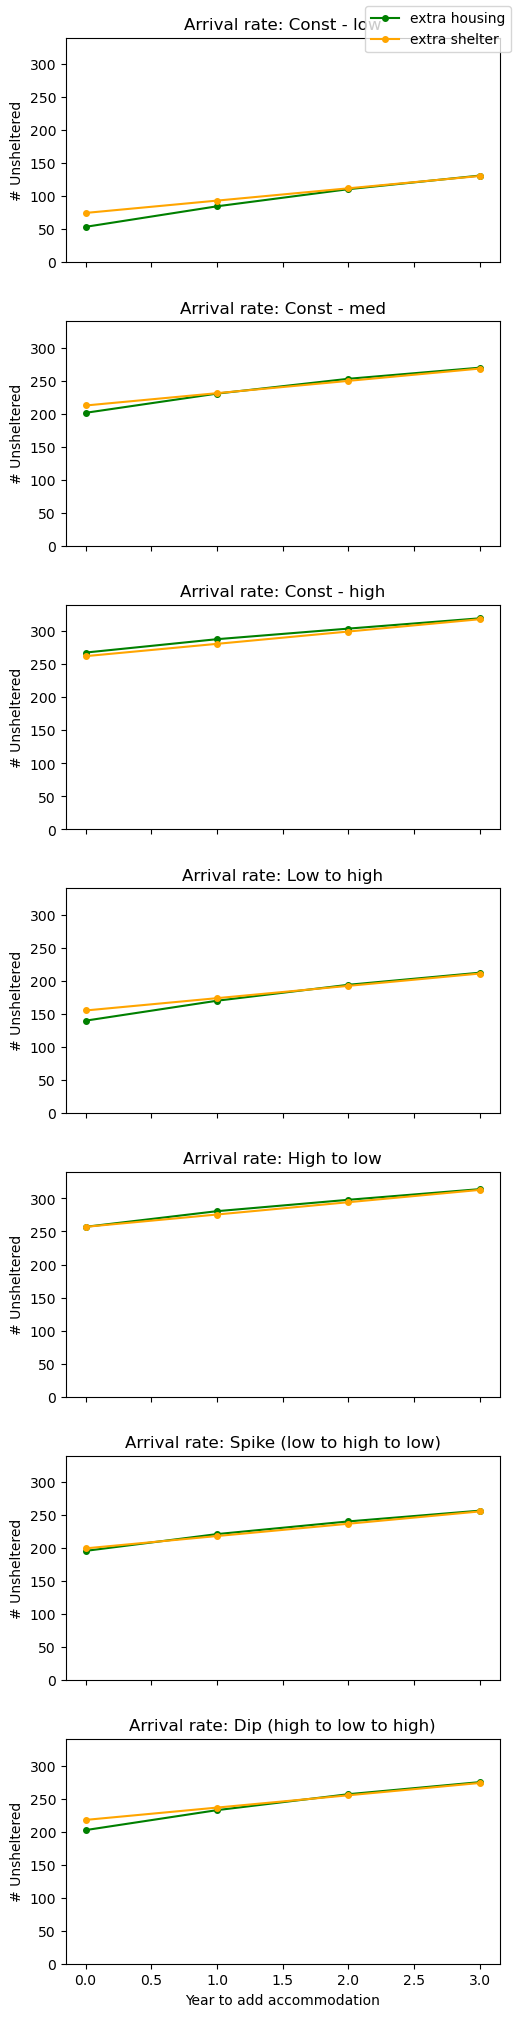

In [185]:
title = 'Arrival rate: '
x = [0,1,2,3]
n_cl = len(arrival_rate_funcs)
fig, axs = plt.subplots(n_cl, figsize=(5, 20))
for j in range(n_cl):
    line1, = axs[j].plot(x, housing_imprv_all3_obj1[j][0], color = 'green', label = 'extra housing', marker='o', markersize = 4)
    line2, = axs[j].plot(x, shelter_imprv_all3_obj1[j][0], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
    axs[j].set_title(title + arrival_rate_func_names[j])
    axs[j].set_ylim(0,340)

#plt.suptitle('Size of unshelter Q vs. \n when we build extra accomm', fontsize = 15)            
fig.legend(handles=[line1, line2]) 
fig.tight_layout()
            
for ax in axs.flat:
    ax.set(xlabel='Year to add accommodation', ylabel='# Unsheltered')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()